In [ ]:
import kagglehub
path = kagglehub.dataset_download("emmarex/plantdisease")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/plantdisease


In [ ]:
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers, models
import keras
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [ ]:
IMAGE_SIZE = 128
BATCH_SIZE = 16
CHANNELS = 3
EPOCHS = 30
DATASET_PATH = "/kaggle/input/plantdisease"
CORRECT_DIRECTORY_PATH = f"{DATASET_PATH}/PlantVillage"

In [ ]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    directory=CORRECT_DIRECTORY_PATH,

    labels='inferred',
    label_mode='int',
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
)

Found 20638 files belonging to 15 classes.


In [ ]:
print(f"Loading images from directory: {CORRECT_DIRECTORY_PATH}")
print("Classes loaded:", dataset.class_names)
print(f"Number of classes loaded: {len(dataset.class_names)}")

Loading images from directory: /kaggle/input/plantdisease/PlantVillage
Classes loaded: ['Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Tomato_Bacterial_spot', 'Tomato_Early_blight', 'Tomato_Late_blight', 'Tomato_Leaf_Mold', 'Tomato_Septoria_leaf_spot', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato__Target_Spot', 'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato__Tomato_mosaic_virus', 'Tomato_healthy']
Number of classes loaded: 15


In [ ]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(16, 128, 128, 3)
[12 10  7 12  5  1  5 12 10  5  8  5  7  7  6  7]


In [ ]:
class_names = dataset.class_names
print(class_names)

['Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Tomato_Bacterial_spot', 'Tomato_Early_blight', 'Tomato_Late_blight', 'Tomato_Leaf_Mold', 'Tomato_Septoria_leaf_spot', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato__Target_Spot', 'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato__Tomato_mosaic_virus', 'Tomato_healthy']


In [ ]:
def get_dataset_partitions(ds, train_split=0.7, test_split=0.1, valid_split=0.2, shuffle=True, shuffle_size=10000):
    assert train_split + test_split + valid_split == 1
    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    train_size = int(len(ds) * train_split)
    valid_size = int(len(ds) * valid_split)

    train_ds = ds.take(train_size)
    valid_ds = ds.skip(train_size).take(valid_size)
    test_ds = ds.skip(train_size).skip(valid_size)

    return train_ds, test_ds, valid_ds

train_ds, test_ds, valid_ds = get_dataset_partitions(dataset)

In [ ]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
valid_ds = valid_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
rescale_and_resize = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1. / 255)
])
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
num_classes = len(class_names)

# RESNET MODEL


In [ ]:
def create_resnet50_model(input_shape, num_classes):
    # Load pre-trained ResNet50 model without top layers
    base_model = ResNet50(
        weights='imagenet',
        include_top=False,
        input_shape=input_shape
    )
    # Freeze the base model
    base_model.trainable = False

    # Create new model on top
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])

    return model


In [ ]:
resnet_model = create_resnet50_model((IMAGE_SIZE, IMAGE_SIZE, CHANNELS), len(class_names))
resnet_model.compile(
    optimizer=optimizers.Adam(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=1e-6
)

In [ ]:
resnet_history = resnet_model.fit(
    train_ds,
    validation_data=valid_ds,
    epochs=30,
    callbacks=[early_stopping, reduce_lr]
)


Epoch 1/30
902/902 ━━━━━━━━━━━━━━━━━━━━ 133s 67ms/step - accuracy: 0.4456 - loss: 1.9068 - val_accuracy: 0.8450 - val_loss: 0.5424 - learning_rate: 1.0000e-04
Epoch 2/30
902/902 ━━━━━━━━━━━━━━━━━━━━ 22s 24ms/step - accuracy: 0.7928 - loss: 0.6445 - val_accuracy: 0.8980 - val_loss: 0.3614 - learning_rate: 1.0000e-04
Epoch 3/30
902/902 ━━━━━━━━━━━━━━━━━━━━ 41s 24ms/step - accuracy: 0.8504 - loss: 0.4712 - val_accuracy: 0.9203 - val_loss: 0.2811 - learning_rate: 1.0000e-04
Epoch 4/30
902/902 ━━━━━━━━━━━━━━━━━━━━ 21s 24ms/step - accuracy: 0.8770 - loss: 0.3732 - val_accuracy: 0.9276 - val_loss: 0.2316 - learning_rate: 1.0000e-04
Epoch 5/30
902/902 ━━━━━━━━━━━━━━━━━━━━ 22s 24ms/step - accuracy: 0.8991 - loss: 0.3156 - val_accuracy: 0.9382 - val_loss: 0.1997 - learning_rate: 1.0000e-04
Epoch 6/30
902/902 ━━━━━━━━━━━━━━━━━━━━ 40s 23ms/step - accuracy: 0.9098 - loss: 0.2708 - val_accuracy: 0.9484 - val_loss: 0.1690 - learning_rate: 1.0000e-04
Epoch 7/30
902/902 ━━━━━━━━━━━━━━━━━━━━ 20s 22ms/st

In [ ]:
def fine_tune_resnet(model, num_layers_to_unfreeze=10):
    # Unfreeze the last num_layers_to_unfreeze layers
    base_model = model.layers[0]
    for layer in base_model.layers[-num_layers_to_unfreeze:]:
        layer.trainable = True

    # model with a lower learning rate
    model.compile(
        optimizer=optimizers.Adam(learning_rate=1e-5),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

In [ ]:
fine_tuned_model = fine_tune_resnet(resnet_model)
fine_tuned_history = fine_tuned_model.fit(
    train_ds,
    validation_data=valid_ds,
    epochs=20,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/20
902/902 ━━━━━━━━━━━━━━━━━━━━ 50s 39ms/step - accuracy: 0.9676 - loss: 0.1024 - val_accuracy: 0.9833 - val_loss: 0.0615 - learning_rate: 1.0000e-05
Epoch 2/20
902/902 ━━━━━━━━━━━━━━━━━━━━ 27s 30ms/step - accuracy: 0.9897 - loss: 0.0393 - val_accuracy: 0.9850 - val_loss: 0.0558 - learning_rate: 1.0000e-05
Epoch 3/20
902/902 ━━━━━━━━━━━━━━━━━━━━ 27s 30ms/step - accuracy: 0.9928 - loss: 0.0295 - val_accuracy: 0.9850 - val_loss: 0.0545 - learning_rate: 1.0000e-05
Epoch 4/20
902/902 ━━━━━━━━━━━━━━━━━━━━ 27s 30ms/step - accuracy: 0.9957 - loss: 0.0220 - val_accuracy: 0.9847 - val_loss: 0.0516 - learning_rate: 1.0000e-05
Epoch 5/20
902/902 ━━━━━━━━━━━━━━━━━━━━ 27s 30ms/step - accuracy: 0.9974 - loss: 0.0158 - val_accuracy: 0.9843 - val_loss: 0.0534 - learning_rate: 1.0000e-05
Epoch 6/20
902/902 ━━━━━━━━━━━━━━━━━━━━ 27s 30ms/step - accuracy: 0.9969 - loss: 0.0148 - val_accuracy: 0.9843 - val_loss: 0.0504 - learning_rate: 1.0000e-05
Epoch 7/20
902/902 ━━━━━━━━━━━━━━━━━━━━ 27s 30ms/ste

In [ ]:
def predict_with_resnet(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.image.resize(img_array, (IMAGE_SIZE, IMAGE_SIZE))
    img_array = tf.expand_dims(img_array, 0)  # Create batch dimension

    predictions = model.predict(img_array)
    class_index = tf.argmax(predictions[0]).numpy()
    predicted_class = class_names[class_index]
    confidence = round(100 * predictions[0][class_index], 2)

    # Parse plant type and condition
    parts = predicted_class.split('___')
    plant_type = parts[0].replace('_', ' ')
    condition = parts[1].replace('_', ' ') if len(parts) > 1 else ''

    return predicted_class, plant_type, condition, confidence

# 9. Evaluate ResNet50 model
resnet_eval = resnet_model.evaluate(test_ds)
print(f"Test Loss: {resnet_eval[0]:.4f}")
print(f"Test Accuracy: {resnet_eval[1]*100:.2f}%")

130/130 ━━━━━━━━━━━━━━━━━━━━ 37s 17ms/step - accuracy: 0.9877 - loss: 0.0519
Test Loss: 0.0401
Test Accuracy: 98.99%


In [ ]:
def save_high_quality_figure(filename, dpi=300):
    plt.savefig(filename, dpi=dpi, bbox_inches='tight')
    print(f"Figure saved as {filename} at {dpi} DPI")


In [ ]:
from sklearn.metrics import classification_report
def generate_classification_report(model, test_dataset, class_names, save_path='classification_report.txt'):
    """Generate classification report with precision, recall, and F1-score"""

    # Initialize lists for true labels and predictions
    y_true = []
    y_pred = []

    # Process dataset in a single pass
    for images, labels in test_dataset:
        # Handle labels (whether they're one-hot encoded or indices)
        if len(labels.shape) > 1 and labels.shape[-1] > 1:  # One-hot encoded
            true_indices = tf.argmax(labels, axis=1).numpy()
        else:  # Already as indices
            true_indices = labels.numpy()

        # Get predictions for this batch
        batch_predictions = model.predict(images, verbose=0)
        batch_pred_classes = np.argmax(batch_predictions, axis=1)

        # Store true labels and predictions
        y_true.extend(true_indices)
        y_pred.extend(batch_pred_classes)

    # Generate report
    report = classification_report(y_true, y_pred, target_names=class_names)
    print("Classification Report:")
    print(report)

    # Save report to file
    with open(save_path, 'w') as f:
        f.write(report)

    return report
report = generate_classification_report(resnet_model, test_ds, class_names)

Classification Report:
                                             precision    recall  f1-score   support

              Pepper__bell___Bacterial_spot       1.00      0.99      1.00       102
                     Pepper__bell___healthy       0.99      0.99      0.99       149
                      Potato___Early_blight       0.99      1.00      1.00       108
                       Potato___Late_blight       1.00      0.98      0.99       112
                           Potato___healthy       0.92      0.92      0.92        13
                      Tomato_Bacterial_spot       1.00      0.99      1.00       226
                        Tomato_Early_blight       0.99      0.99      0.99        83
                         Tomato_Late_blight       0.97      0.98      0.97       173
                           Tomato_Leaf_Mold       1.00      1.00      1.00       102
                  Tomato_Septoria_leaf_spot       0.99      0.99      0.99       185
Tomato_Spider_mites_Two_spotted_spider_mi

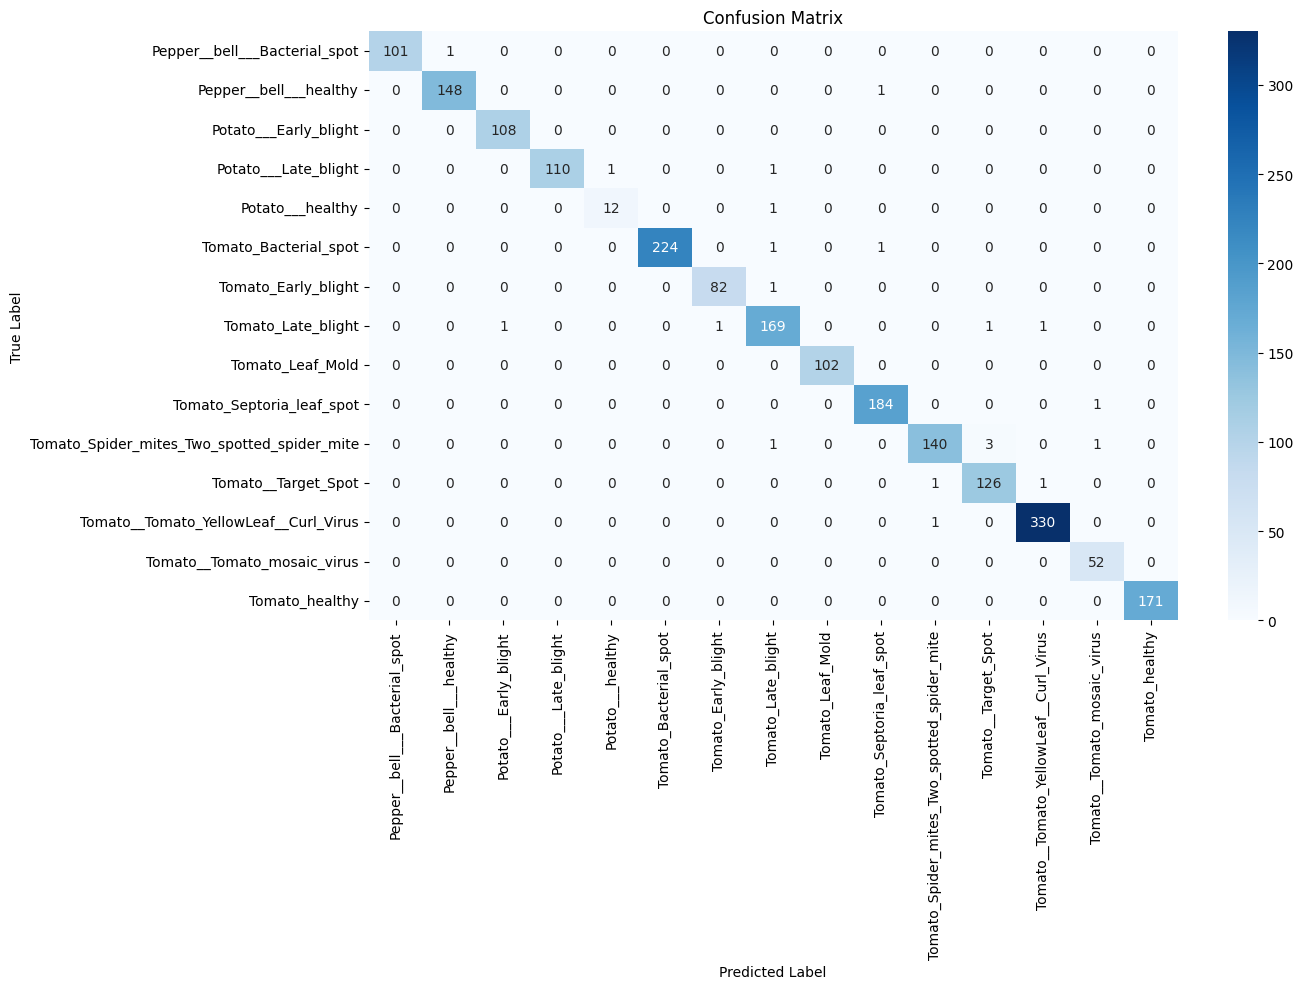

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(model, test_dataset, class_names, save_path='confusion_matrix.png'):
    """Generate and plot confusion matrix from model predictions (single-pass, batch-wise)"""
    y_true = []
    y_pred = []

    for images, labels in test_dataset:
        # Handle labels (one-hot or indices)
        if len(labels.shape) > 1 and labels.shape[-1] > 1:
            true_indices = np.argmax(labels, axis=1)
        else:
            true_indices = labels.numpy()

        # Get predictions for this batch
        batch_pred = model.predict(images, verbose=0)
        pred_indices = np.argmax(batch_pred, axis=1)

        # Store true labels and predictions
        y_true.extend(true_indices)
        y_pred.extend(pred_indices)

    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(14, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.savefig(save_path, dpi=300)
    plt.show()

    return cm

# Use this to generate your confusion matrix
cm = plot_confusion_matrix(resnet_model, test_ds, class_names)


Figure saved as training_history.png at 300 DPI


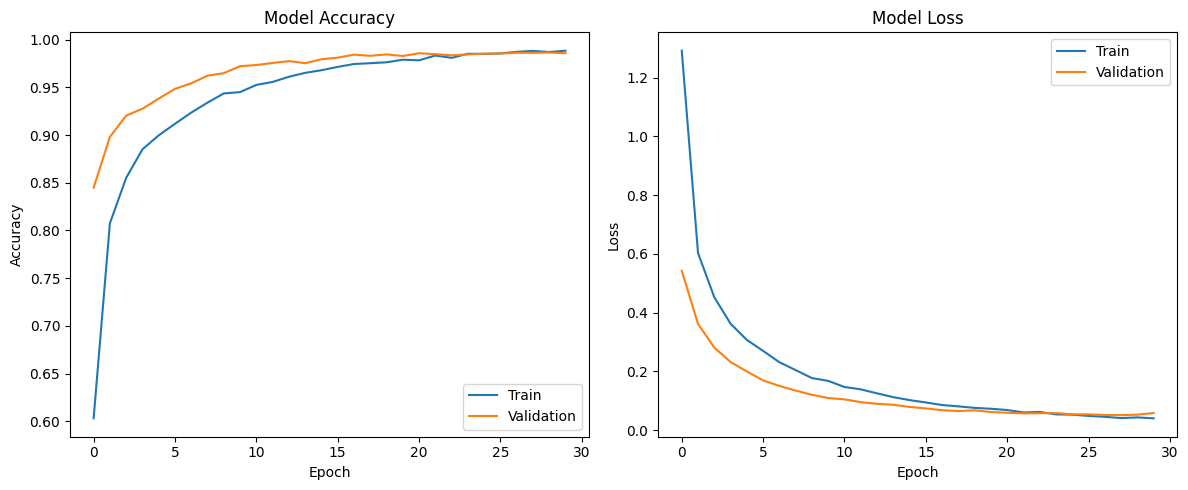

In [ ]:
import matplotlib.pyplot as plt

def plot_training_history(history, save_path='training_history.png'):
    """Plot and save the model's training history"""
    plt.figure(figsize=(12, 5))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='lower right')

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper right')

    plt.tight_layout()
    save_high_quality_figure(save_path)
    plt.show()

# Example usage
plot_training_history(resnet_history)


In [ ]:
from tensorflow.keras.utils import plot_model

def visualize_model_architecture(model, save_path='model_architecture.png'):
    """Visualize and save the model architecture"""

    plot_model(model, to_file=save_path, show_shapes=True, show_layer_names=True, dpi=300)


    model.summary()

    print(f"Model architecture saved to {save_path}")


visualize_model_architecture(resnet_model)



Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 4, 4, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 15)             │         3,855 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 34,104,239 (130.10 MB)

 Trainable params: 4,994,063 (19.05 MB)

 Non-trainable params: 19,122,048 (72.94 MB)

 Optimizer params: 9,988,128 (38.10 MB)

Model architecture saved to model_architecture.png


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━

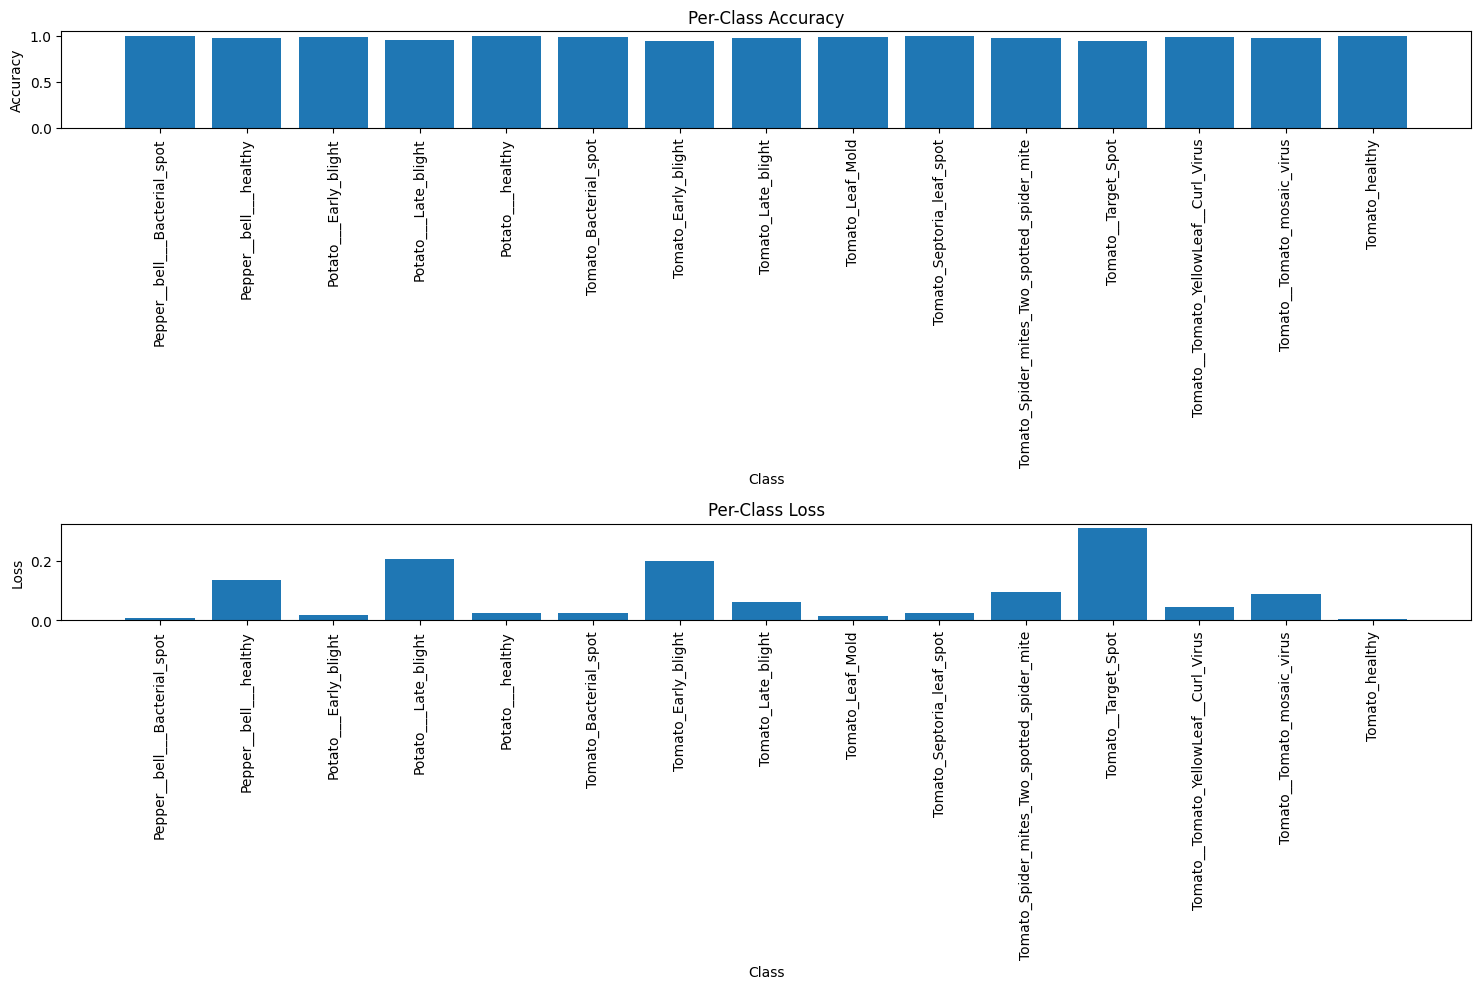

In [ ]:
def calculate_per_class_metrics(model, test_dataset, class_names, save_path='per_class_metrics.png'):
    """Calculate and visualize accuracy and loss for each class"""

    y_true = []
    all_predictions = []

    for images, labels in test_dataset:
        batch_preds = model.predict(images)
        all_predictions.extend(batch_preds)
        y_true.extend(labels.numpy())

    y_true = np.array(y_true)
    all_predictions = np.array(all_predictions)
    y_pred = np.argmax(all_predictions, axis=1)


    class_accuracy = []
    class_loss = []

    for i in range(len(class_names)):

        idx = (y_true == i)
        if np.sum(idx) > 0:

            class_acc = np.mean(y_pred[idx] == y_true[idx])
            class_accuracy.append(class_acc)


            true_one_hot = np.zeros(len(class_names))
            true_one_hot[i] = 1
            class_losses = []
            for pred in all_predictions[idx]:

                loss = -np.sum(true_one_hot * np.log(np.clip(pred, 1e-10, 1.0)))
                class_losses.append(loss)
            class_loss.append(np.mean(class_losses))
        else:
            class_accuracy.append(0)
            class_loss.append(0)


    plt.figure(figsize=(15, 10))


    plt.subplot(2, 1, 1)
    x = np.arange(len(class_names))
    plt.bar(x, class_accuracy)
    plt.xlabel('Class')
    plt.ylabel('Accuracy')
    plt.title('Per-Class Accuracy')
    plt.xticks(x, class_names, rotation=90)


    plt.subplot(2, 1, 2)
    plt.bar(x, class_loss)
    plt.xlabel('Class')
    plt.ylabel('Loss')
    plt.title('Per-Class Loss')
    plt.xticks(x, class_names, rotation=90)

    plt.tight_layout()
    save_high_quality_figure(save_path)
    plt.show()

    return class_accuracy, class_loss


per_class_acc, per_class_loss = calculate_per_class_metrics(resnet_model, test_ds, class_names)


Figure saved as data_distribution.png at 300 DPI


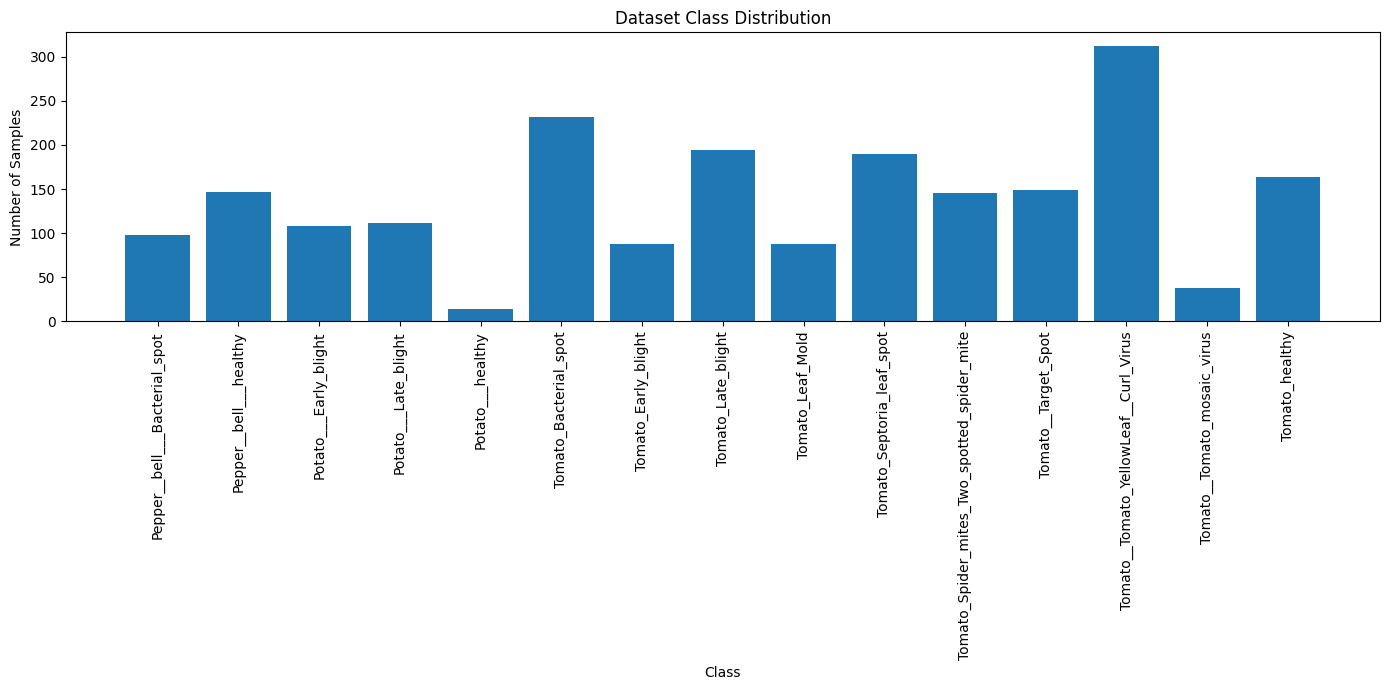

In [ ]:
def visualize_data_distribution(dataset, class_names, save_path='data_distribution.png'):
    """Visualize the distribution of classes in the dataset"""

    class_counts = {}
    for _, labels in dataset:
        for label in labels.numpy():
            if label in class_counts:
                class_counts[label] += 1
            else:
                class_counts[label] = 1


    sorted_counts = {k: class_counts.get(k, 0) for k in range(len(class_names))}


    plt.figure(figsize=(14, 7))
    x = np.arange(len(class_names))
    plt.bar(x, list(sorted_counts.values()))
    plt.xlabel('Class')
    plt.ylabel('Number of Samples')
    plt.title('Dataset Class Distribution')
    plt.xticks(x, class_names, rotation=90)

    plt.tight_layout()
    save_high_quality_figure(save_path)
    plt.show()

    return sorted_counts


class_distribution = visualize_data_distribution(test_ds, class_names)


130/130 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step
Figure saved as roc_curves.png at 300 DPI


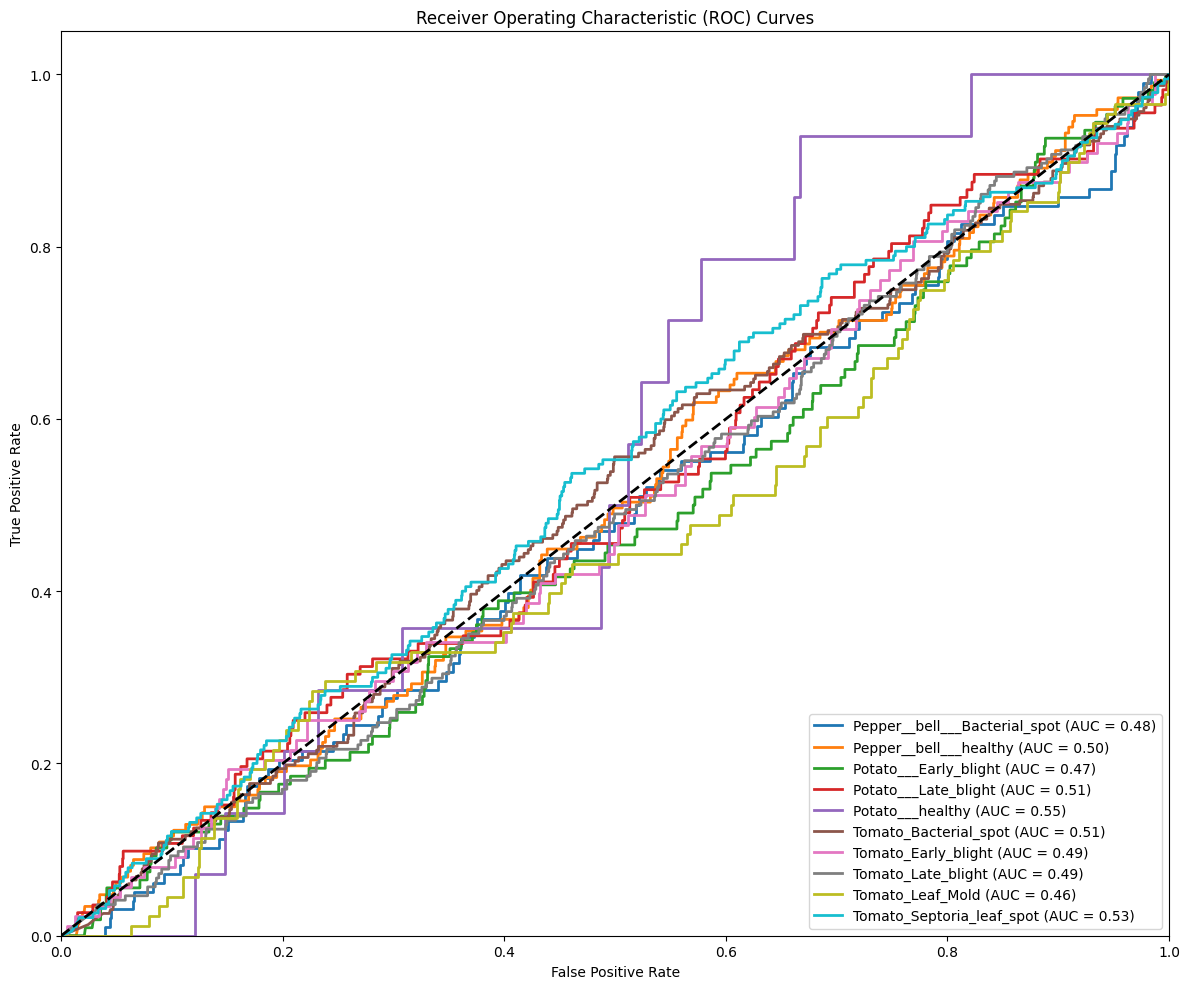

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

def plot_roc_curves(model, test_dataset, class_names, save_path='roc_curves.png'):
    """Plot and save ROC curves for each class"""
    # Get true labels
    y_true = []
    for images, labels in test_dataset:
        y_true.extend(labels.numpy())
    y_true = np.array(y_true)

    # predicted probabilty
    y_pred_prob = model.predict(test_dataset)

    #binary labels add krne ke liye
    y_true_bin = label_binarize(y_true, classes=range(len(class_names)))


    plt.figure(figsize=(12, 10))


    plot_classes = min(len(class_names), 10)  # 10 classes ka plot krne ke liye
    for i in range(plot_classes):
        fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_pred_prob[:, i])
        roc_auc = auc(fpr, tpr)

        plt.plot(fpr, tpr, lw=2, label=f'{class_names[i]} (AUC = {roc_auc:.2f})')


    plt.plot([0, 1], [0, 1], 'k--', lw=2)

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curves')
    plt.legend(loc="lower right")

    plt.tight_layout()
    save_high_quality_figure(save_path)
    plt.show()


plot_roc_curves(fine_tuned_model, test_ds, class_names)



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━

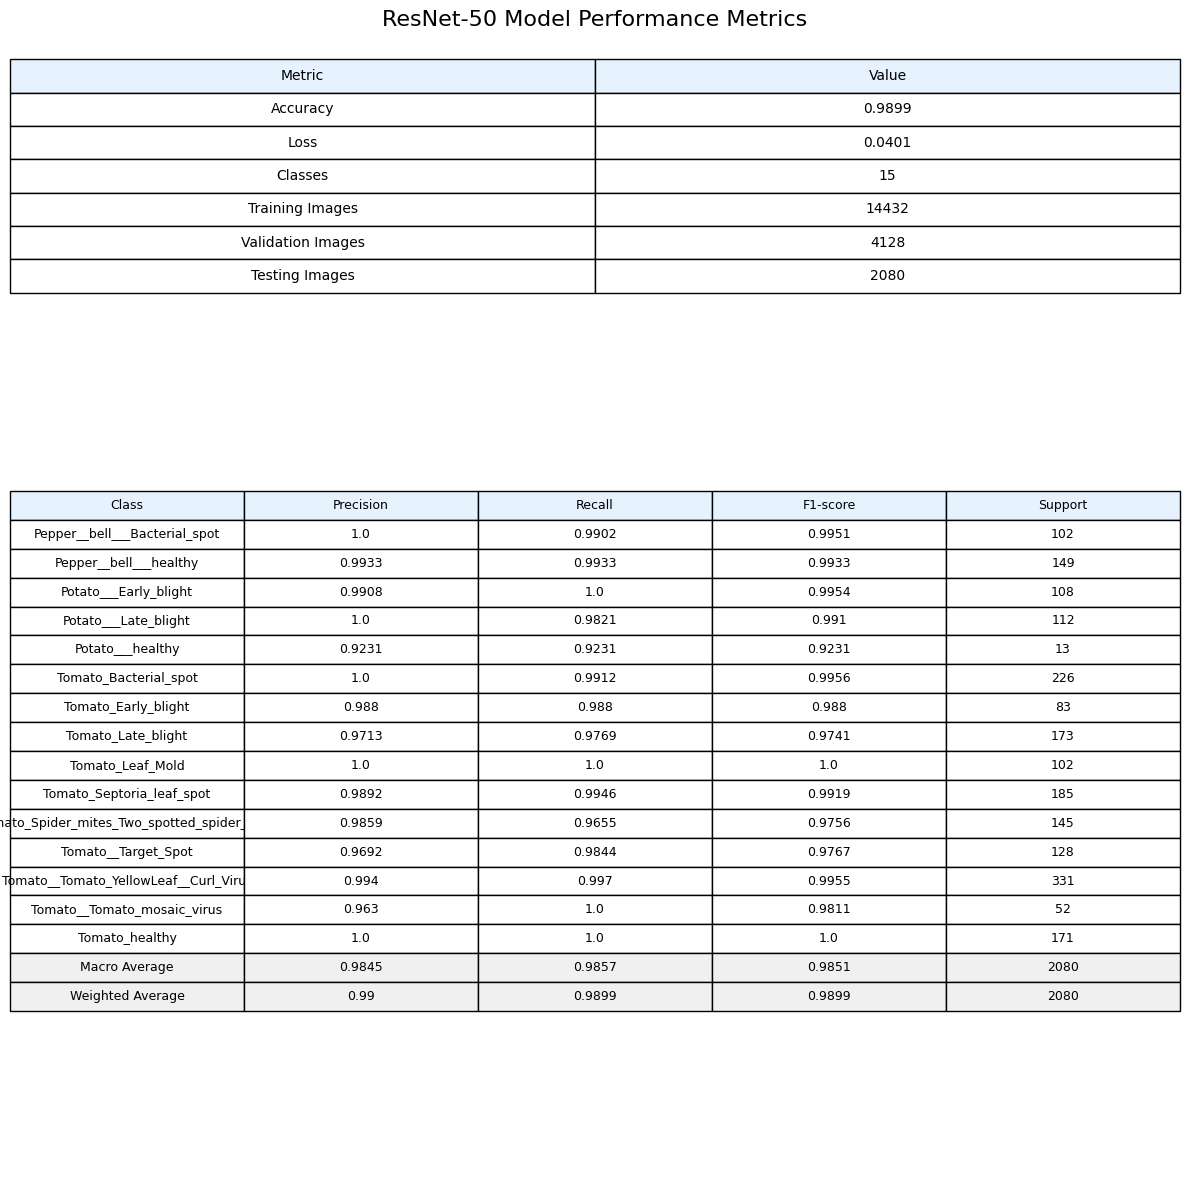

Overall Performance Metrics:
           Metric  Value
         Accuracy 0.9899
             Loss 0.0401
          Classes     15
  Training Images  14432
Validation Images   4128
   Testing Images   2080

Per-Class Performance Metrics:
                                      Class  Precision  Recall  F1-score  Support
              Pepper__bell___Bacterial_spot     1.0000  0.9902    0.9951      102
                     Pepper__bell___healthy     0.9933  0.9933    0.9933      149
                      Potato___Early_blight     0.9908  1.0000    0.9954      108
                       Potato___Late_blight     1.0000  0.9821    0.9910      112
                           Potato___healthy     0.9231  0.9231    0.9231       13
                      Tomato_Bacterial_spot     1.0000  0.9912    0.9956      226
                        Tomato_Early_blight     0.9880  0.9880    0.9880       83
                         Tomato_Late_blight     0.9713  0.9769    0.9741      173
                          

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
import tensorflow as tf

def generate_performance_metrics_table(model, test_dataset, class_names, save_path='performance_metrics_table.png'):
    """
    Generate and save a table of performance metrics for the model
    """

    y_true = []
    y_pred = []


    for images, labels in test_dataset:
        predictions = model.predict(images)
        pred_labels = np.argmax(predictions, axis=1)

        y_true.extend(labels.numpy())
        y_pred.extend(pred_labels)


    accuracy = np.mean(np.array(y_true) == np.array(y_pred))


    precision, recall, f1, support = precision_recall_fscore_support(
        y_true, y_pred, average=None, labels=range(len(class_names))
    )


    class_metrics_df = pd.DataFrame({
        'Class': class_names,
        'Precision': precision,
        'Recall': recall,
        'F1-score': f1,
        'Support': support
    })


    macro_precision, macro_recall, macro_f1, _ = precision_recall_fscore_support(
        y_true, y_pred, average='macro'
    )


    weighted_precision, weighted_recall, weighted_f1, _ = precision_recall_fscore_support(
        y_true, y_pred, average='weighted'
    )


    macro_row = pd.DataFrame({
        'Class': ['Macro Average'],
        'Precision': [macro_precision],
        'Recall': [macro_recall],
        'F1-score': [macro_f1],
        'Support': [sum(support)]
    })


    weighted_row = pd.DataFrame({
        'Class': ['Weighted Average'],
        'Precision': [weighted_precision],
        'Recall': [weighted_recall],
        'F1-score': [weighted_f1],
        'Support': [sum(support)]
    })

    #concat df
    metrics_df = pd.concat([class_metrics_df, macro_row, weighted_row])


    metrics_df['Precision'] = metrics_df['Precision'].round(4)
    metrics_df['Recall'] = metrics_df['Recall'].round(4)
    metrics_df['F1-score'] = metrics_df['F1-score'].round(4)


    overall_metrics = {
        'Metric': ['Accuracy', 'Loss', 'Classes', 'Training Images', 'Validation Images', 'Testing Images'],
        'Value': [
            f"{accuracy:.4f}",
            f"{model.evaluate(test_dataset, verbose=0)[0]:.4f}",
            len(class_names),
            sum(len(batch[0]) for batch in train_ds),
            sum(len(batch[0]) for batch in valid_ds),
            sum(len(batch[0]) for batch in test_ds)
        ]
    }

    overall_df = pd.DataFrame(overall_metrics)


    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12), gridspec_kw={'height_ratios': [1, 3]})


    ax1.axis('tight')
    ax1.axis('off')
    ax2.axis('tight')
    ax2.axis('off')


    overall_table = ax1.table(
        cellText=overall_df.values,
        colLabels=overall_df.columns,
        cellLoc='center',
        loc='center',
        colColours=['#e6f3ff']*2
    )
    overall_table.auto_set_font_size(False)
    overall_table.set_fontsize(10)
    overall_table.scale(1, 1.5)

    class_table = ax2.table(
        cellText=metrics_df.values,
        colLabels=metrics_df.columns,
        cellLoc='center',
        loc='center',
        colColours=['#e6f3ff']*5
    )
    class_table.auto_set_font_size(False)
    class_table.set_fontsize(9)
    class_table.scale(1, 1.3)

    #color krdo bhai
    for i in range(len(class_names), len(class_names)+2):
        for j in range(5):
            cell = class_table.get_celld()[i+1, j]
            cell.set_facecolor('#f0f0f0')


    plt.suptitle('ResNet-50 Model Performance Metrics', fontsize=16, y=0.98)


    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

    return metrics_df, overall_df


metrics_df, overall_df = generate_performance_metrics_table(
    fine_tuned_model,
    test_ds,
    class_names,
    save_path='resnet50_performance_metrics.png'
)


print("Overall Performance Metrics:")
print(overall_df.to_string(index=False))
print("\nPer-Class Performance Metrics:")
print(metrics_df.to_string(index=False))


Classification Report:
                                             precision    recall  f1-score   support

              Pepper__bell___Bacterial_spot       1.00      0.97      0.98       207
                     Pepper__bell___healthy       0.99      1.00      0.99       279
                      Potato___Early_blight       0.99      1.00      0.99       203
                       Potato___Late_blight       0.97      0.98      0.98       202
                           Potato___healthy       0.96      0.96      0.96        28
                      Tomato_Bacterial_spot       0.99      1.00      0.99       437
                        Tomato_Early_blight       0.98      0.90      0.94       215
                         Tomato_Late_blight       0.97      0.98      0.97       388
                           Tomato_Leaf_Mold       0.98      1.00      0.99       191
                  Tomato_Septoria_leaf_spot       0.99      0.99      0.99       338
Tomato_Spider_mites_Two_spotted_spider_mi

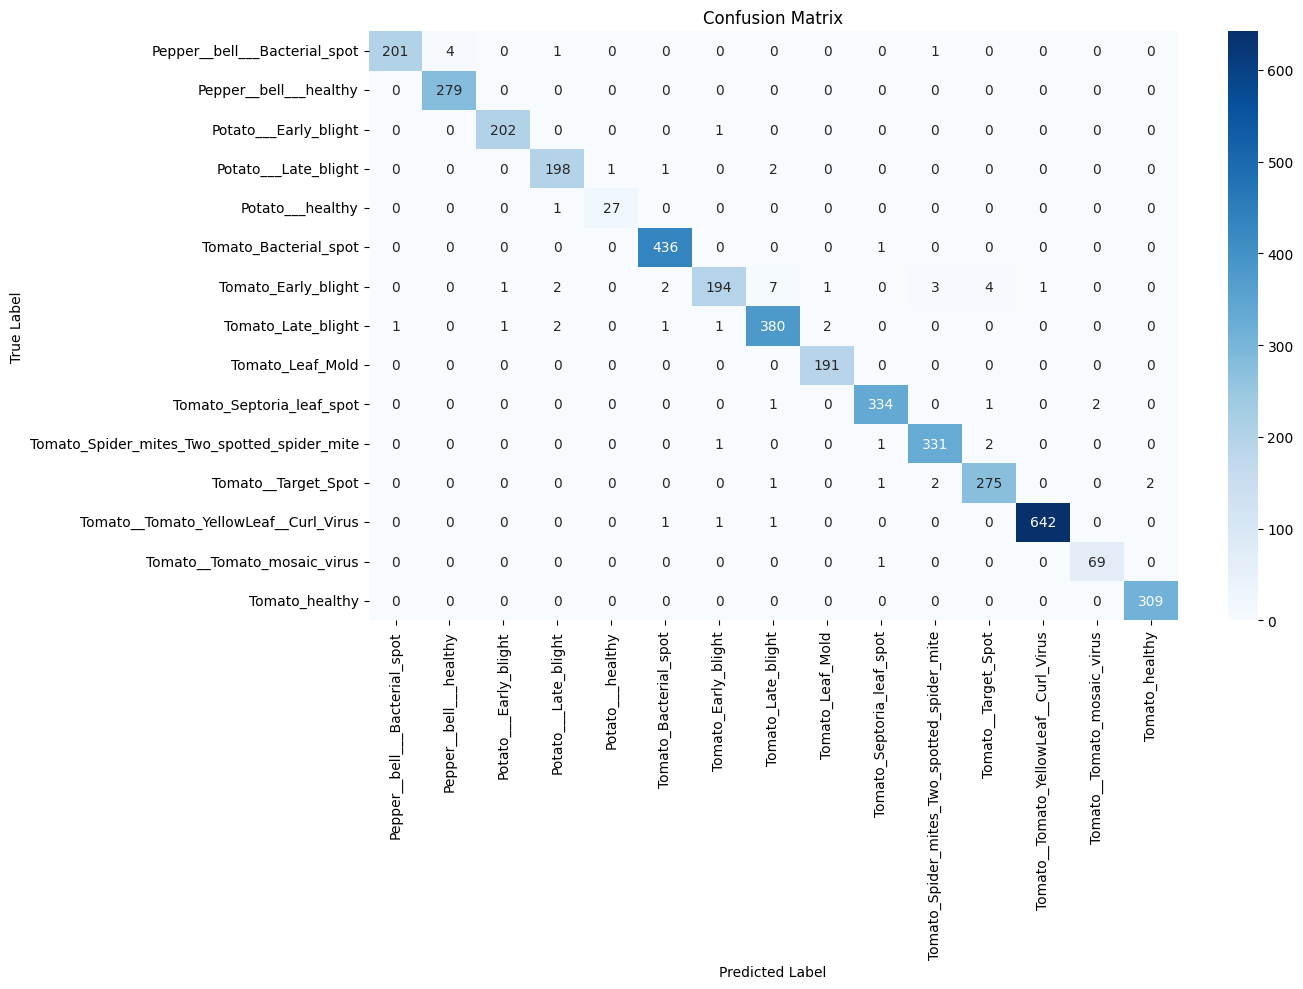

In [ ]:
# Classification report for validation data
val_report = generate_classification_report(resnet_model, valid_ds, class_names,
                                           save_path='validation_report.txt')

# Confusion matrix for validation data
val_cm = plot_confusion_matrix(resnet_model, valid_ds, class_names,
                              save_path='validation_confusion_matrix.png')
